# Installing Dependencies

In [1]:
pip_list = !pip list
packages = ["chardet", "keras-tuner", "mysql-connector-python", "numpy", "pandas", "sklearn", "spacy", "statsmodels", "tensorflow"]
for package in packages:
    if not pip_list.grep(package):
        !pip3 install {package}

print("Package installations completed.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 47.6 MB/s eta 0:00:0000:0100:01
Package installations completed.


# Importing Libraries

In [2]:
import calendar
import datetime
import os
import random
import shutil
import warnings
from io import BytesIO
from pickle import dump

import chardet
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import mysql.connector
import numpy as np
import pandas as pd
import requests
import scipy.stats as stat
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import torch
from IPython.display import display
from keras_tuner.tuners import BayesianOptimization, Hyperband, RandomSearch
from mysql.connector import errorcode
from PIL import Image
from sklearn import set_config
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectPercentile, VarianceThreshold
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.utils import class_weight
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib
from torch.utils.data import Dataset, random_split
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TFAutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)

%matplotlib inline
time_stamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
set_config(display="diagram", print_changed_only=False)
pd.set_option("display.float_format", lambda f: "%.2f" % f)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
plt.rc("axes", labelsize=12)
plt.rc("axes", titlesize=12)
plt.rc("font", size=10)
plt.rcParams["figure.figsize"] = [18, 7]
plt.style.use("dark_background")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
warnings.filterwarnings("ignore")

print(device_lib.list_local_devices())
print(tf.config.list_physical_devices("GPU"))
print(tf.test.gpu_device_name())
print(os.system("cat /proc/cpuinfo | grep 'model name'"))
print(os.system("cat /proc/meminfo | grep 'MemTotal'"))
print(os.system("nvidia-smi"))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10627559596076118133
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15774515200
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4435692630030628529
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
0
MemTotal:       16390828 kB
0
Wed Jun 14 03:10:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. 

# Connecting to SQL

In [3]:
try:
    conn = mysql.connector.connect(
        user="user",
        password=os.environ["SQL_CONN_STRING"],
        host="mysqlserver.mysql.database.azure.com",
        port=3306,
        database="",
        ssl_ca="{ca-cert filename}",
        ssl_disabled=False,
    )
    print("Connection established")

except mysql.connector.Error as e:
    if e.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with the user name or password")
    elif e.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
    else:
        print(e)
else:
    tables = {table: pd.read_sql(f"""SELECT * FROM {table};""", conn) for table in pd.read_sql("SHOW TABLES", conn).iloc[:, 0]}
    for table_name, table_dataframe in tables.items():
        print(f"-------------------------------------------------------\nTable: {table_name}")
        display(table_dataframe)
    conn.close()
    print(f"Discovered table(s): {len(tables)}.\nDB Connection closed.")


# Merging Tables

In [4]:
url = "https://raw.githubusercontent.com/lyoh001/AzureML/main"
df1 = pd.read_csv(f"{url}/1.csv", delimiter=",", thousands=",")
df2 = pd.read_csv(f"{url}/2.csv", delimiter=",", thousands=",")
description = ["1", "2"]
for desc, df_temp in zip(description, [df1, df2]):
    print(f"-------------------------------------------------------\n{desc}")
    df_temp = df_temp.copy()
    for col in df_temp.columns:
        print(f"{col}: {df_temp[col].nunique()}")
    display(df_temp)

for table_name, table_dataframe in tables.items():
    print(f"-------------------------------------------------------\nTable: {table_name}\nColumns: {table_dataframe.columns}\nShape: {table_dataframe.shape}")
df.rename({"": ""}, axis=1, inplace=True)
df = pd.merge(left=tables[""], right=tables[""], left_on="", right_on="", how="left", indicator=False)
df = pd.merge(left=df, right=tables[""], left_on="", right_on="", how="left", indicator=False)
display(df)


# Reading Data

In [23]:
display(df)

,title
0,The Three Bay Areas
1,The First Gene-Edited Squid in History Is a Bi...
2,The Gig Economy Is Failing. Say Hello to the H...
3,10 Bizarre Money Habits Making Millennials Richer
4,Google's Remote Work Policy Has 9 Great Tips Y...
...,...
2696,Decapitating Consciousness
2697,A Career Retrospective—10 years working in tech
2698,How reader engagement helped unearth the Shell...
2699,A History and Future of the Rise of the Robots


# Defining Parameters

In [6]:
RANDOM_STATE = 11
SEARCH = ["hyperband", "random", "bayesian"][0]
MAX_TRIALS = 20
DUPLICATES = 0
SCALER = 1
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DATA_BALANCE = 1
NUM_BINS = 30
SAMPLE_SIZE = 4_000
PRETRAINED_MODEL = [
    "distilbert-base-uncased",
    "bert-base-uncased",
    "roberta-base",
    "xlnet-base-cased",
    "albert-base-v2",
    "google/electra-base-discriminator",
    "gpt2",
][-1]
NLP = 0
CLASSIFICATION = 0
EPOCHS = 50 if NLP else 10

print("-------------------------------------------------------")
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"Duplicates Percentage: {df.duplicated().sum() / df.shape[0] * 100:.2f}%")
if DUPLICATES:
    print(f"Duplicates have been kept {df.shape}.")
else:
    df.drop_duplicates(inplace=True)
    print(f"Duplicates have been removed {df.shape}.")
display(df.sample(3))

x_label = "title"
y_label = "title"


-------------------------------------------------------
Current Shape: (2701, 8).
-------------------------------------------------------
Duplicates Percentage: 0.00%
Duplicates have been removed (2701, 8).


,Unnamed: 0,title,author,publication,date,duration,claps,tags
974,974,A RealWorld Comparison of Front-End Frameworks...,jacek schae,freecodecamp.org,8-Apr-19,6,8800,"javascript,web-development,software-developmen..."
2646,2646,Why Pro Matters,sebastiaan de with,No Publication,6-Apr-17,8,1100,"apple,tech,creative,design,apps"
112,112,The Best Way to Develop Your Team Isn't Feedback,dave bailey,the founder coach,21-May,5,4600,"management,leadership,self-improvement,psychol..."


# Mapping Target Values

In [7]:
df.dropna(subset=[y_label], axis=0, inplace=True)
print("-------------------------------------------------------")
print(f"Dropping null target values.")
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")

-------------------------------------------------------
Dropping null target values.
Current Shape: (2701, 8).
-------------------------------------------------------


# Correlation Matrix

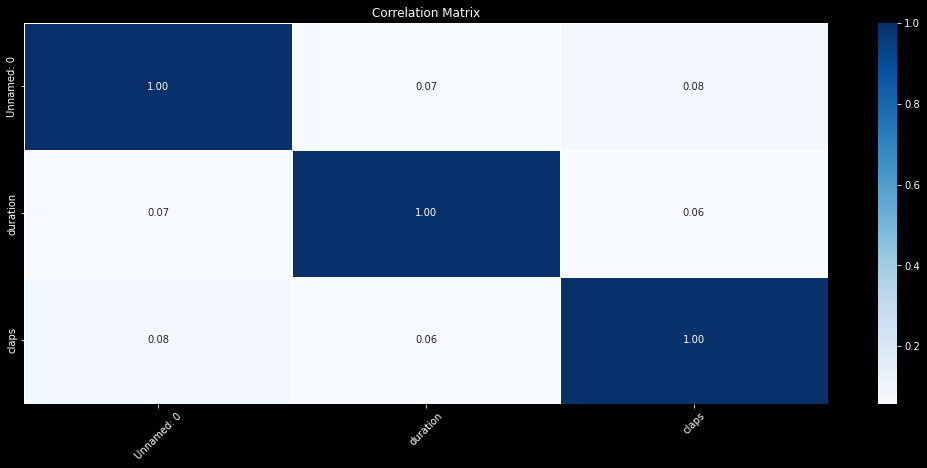

In [8]:
sns.heatmap(df.corr(), cmap="Blues", fmt=".2f", annot=True, linewidths=1)
plt.title("Correlation Matrix")
plt.xticks(rotation=45)
plt.show()


# Eliminating Multicollinearity between Features

In [9]:
def correlation(X, threshold):
    col_corr = set()
    df_corr = X.corr().abs()
    for i, _ in enumerate(df_corr.columns):
        for j in range(i):
            if (df_corr.iloc[i, j] >= threshold) and (
                df_corr.columns[j] not in col_corr
            ):
                col_corr.add(df_corr.columns[i])
    return col_corr


col_drop = correlation(df.drop(y_label, axis=1), 0.85)
df.drop(col_drop, inplace=True, axis=1)
print("-------------------------------------------------------")
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"Highly correlated cols have been removed: {len(col_drop)}.")
print(f"Highly correlated cols: {col_drop}.")


-------------------------------------------------------
Current Shape: (2701, 8).
-------------------------------------------------------
Highly correlated cols have been removed: 0.
Highly correlated cols: set().


# Checking NULL Values

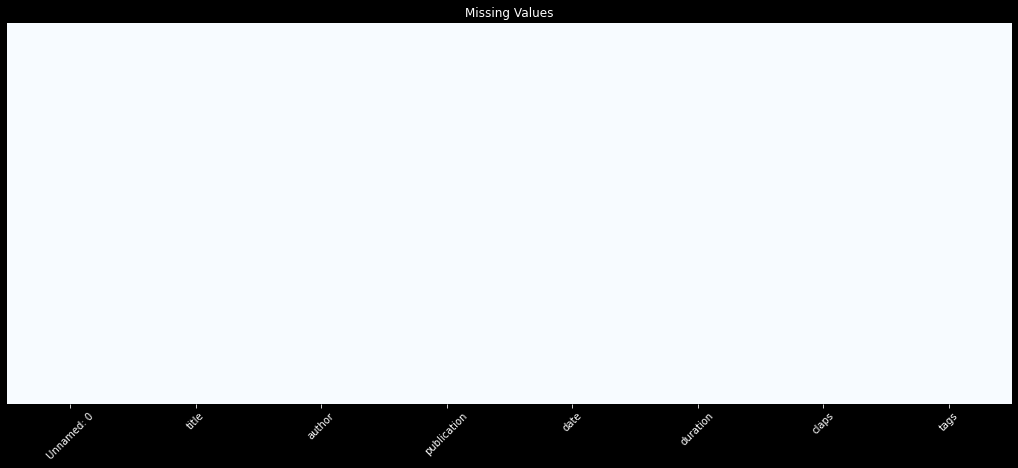

In [10]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap="Blues")
plt.title("Missing Values")
plt.xticks(rotation=45)
plt.show()


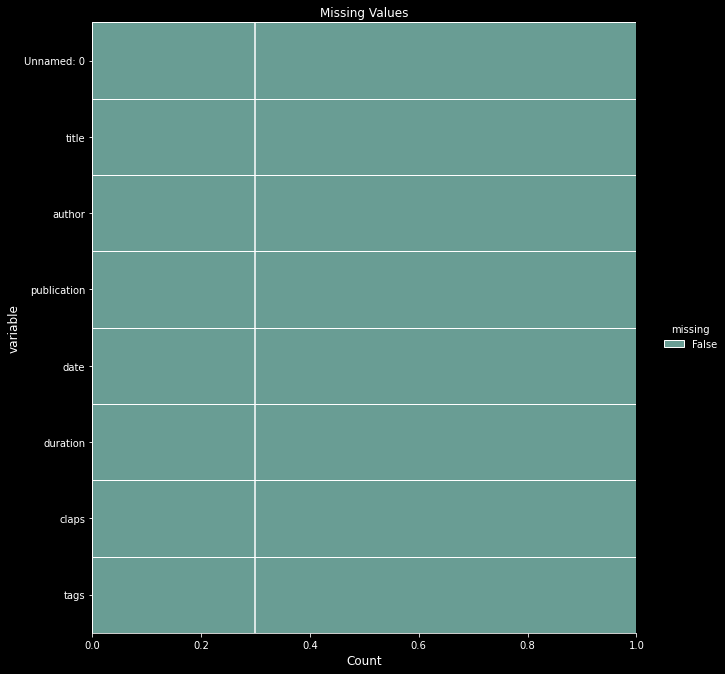

In [11]:
sns.displot(
    data=df.isnull().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    height=9.25,
)
plt.axvline(0.3, color="white")
plt.title("Missing Values")
plt.show()


# Data Wrangling

In [12]:
df.dropna(subset=[x_label], axis=0, inplace=True)
df.drop(
    ["Unnamed: 0", "author", "publication", "date", "duration", "claps", "tags"],
    axis=1,
    inplace=True,
)

# Feature Description

In [13]:
col_cat_cv = [x_label]
col_cat_oe = []
preprocessor_cat_oe = make_pipeline(
    (SimpleImputer(strategy="constant", fill_value="missing")),
    (OrdinalEncoder(categories=[["", ""]])),
)
col_cat = [
    col
    for col in df.columns
    if np.issubsctype(df[col].dtype, np.object0)
    and col != y_label
    and col not in col_cat_cv
]
col_num = [
    col
    for col in df.columns
    if np.issubsctype(df[col].dtype, np.number) and col != y_label
]
col_cat_ohe = [col for col in col_cat if col not in col_cat_oe + col_cat_cv]
col_num_disc = [col for col in col_num if df[col].nunique() <= 10]
col_num_cont = [col for col in col_num if col not in col_num_disc]

df_info = pd.DataFrame(
    {
        "column": [col for col in df.columns],
        "dtype": [f"{df[col].dtype}" for col in df.columns],
        "na": [f"{df[col].isna().sum()}" for col in df.columns],
        "na %": [
            f"{round(df[col].isna().sum() / df[col].shape[0] * 100)}%"
            for col in df.columns
        ],
        "outliers": [
            f"{((df[col] < (df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)))) | (df[col] > (df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))))).sum()}"
            if col in col_num
            else "n/a"
            for col in df.columns
        ],
        "outliers %": [
            f"{round((((df[col] < (df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)))) | (df[col] > (df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))))).sum()) / df[col].shape[0] * 100)}%"
            if col in col_num
            else "n/a"
            for col in df.columns
        ],
        "kurtosis": [
            f"{df[col].kurtosis(axis=0, skipna=True):.2f}" if col in col_num else "n/a"
            for col in df.columns
        ],
        "skewness": [
            f"{df[col].skew(axis=0, skipna=True):.2f}" if col in col_num else "n/a"
            for col in df.columns
        ],
        "corr": [
            f"{round(df[col].corr(other=df[y_label]) * 100)}%"
            if col in col_num
            else "n/a"
            for col in df.columns
        ],
        "nunique": [f"{df[col].nunique()}" for col in df.columns],
        "unique": [
            sorted(df[col].unique()) if col in col_num else df[col].unique()
            for col in df.columns
        ],
    }
).sort_values(by="dtype", ascending=False)
display(df_info)
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"total na %: {df.isnull().sum().sum() / np.product(df.shape) * 100:.2f}%")
print("-------------------------------------------------------")
print(f"col_cat_oe ({len(col_cat_oe)}): {col_cat_oe}")
print(f"col_cat_ohe ({len(col_cat_ohe)}): {col_cat_ohe}")
print(f"col_cat_cv ({len(col_cat_cv)}): {col_cat_cv}")
print(f"col_num_disc ({len(col_num_disc)}): {col_num_disc}")
print(f"col_num_cont ({len(col_num_cont)}): {col_num_cont}")
print("-------------------------------------------------------")
print(
    f"total cols for preprocessor: {len(col_cat_oe) + len(col_cat_ohe) + len(col_cat_cv) + len(col_num_disc) + len(col_num_cont)}"
)


,column,dtype,na,na %,outliers,outliers %,kurtosis,skewness,corr,nunique,unique
0,title,object,0,0%,n/a,n/a,n/a,n/a,n/a,2697,"[The Three Bay Areas, The First Gene-Edited Sq..."


Current Shape: (2701, 1).
-------------------------------------------------------
total na %: 0.00%
-------------------------------------------------------
col_cat_oe (0): []
col_cat_ohe (0): []
col_cat_cv (1): ['title']
col_num_disc (0): []
col_num_cont (0): []
-------------------------------------------------------
total cols for preprocessor: 1


# Frequency Encoding (http://proceedings.mlr.press/v7/niculescu09/niculescu09.pdf)

In [14]:
for col in col_cat_ohe:
    sr_temp = df.groupby(col)[y_label].count() / df.shape[0]
    df_temp = sr_temp[sr_temp > 0.01].index
    df[col] = np.where(df[col].isin(df_temp), df[col], "-")


# Count Encoding (http://proceedings.mlr.press/v7/niculescu09/niculescu09.pdf)

In [15]:
MAX_COLS = 100
for col in col_cat_ohe:
    indice = df[col].value_counts()[:MAX_COLS].index
    df_temp = df[col].map(lambda value: value if value in indice else "-")
    # df[col] = df_temp
    print(df_temp.value_counts())
    print(f"unique values: {df_temp.nunique()}")
    print("-------------------------------------------------------")
try:
    display(df.describe(exclude="number").T.style.background_gradient(cmap="Blues"))
except Exception:
    pass


,count,unique,top,freq
title,2701,2697,You're Angrier Than You Think,4


# Preprocessing and Visualizing NLP

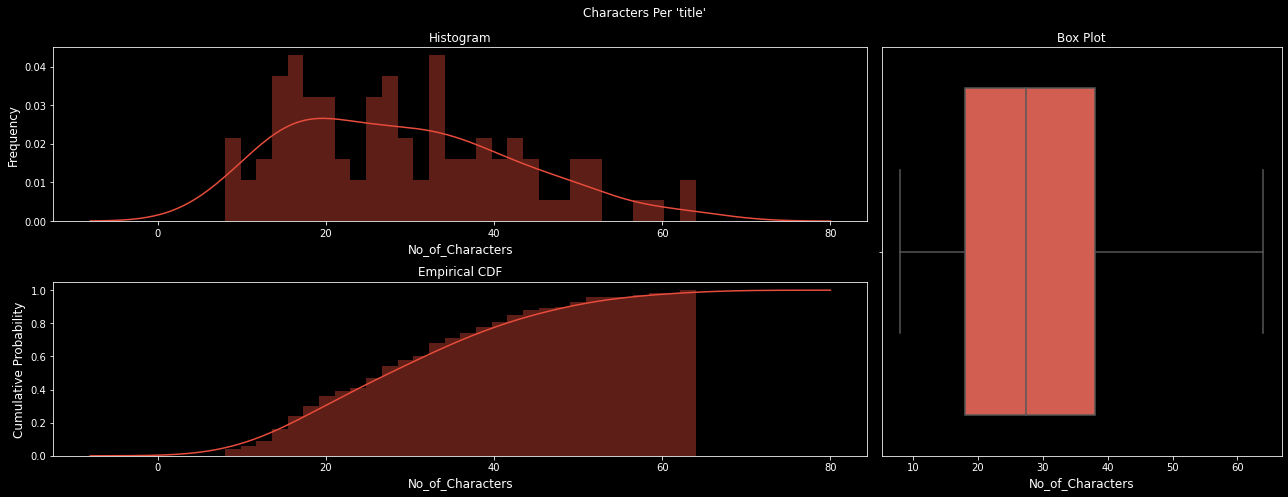

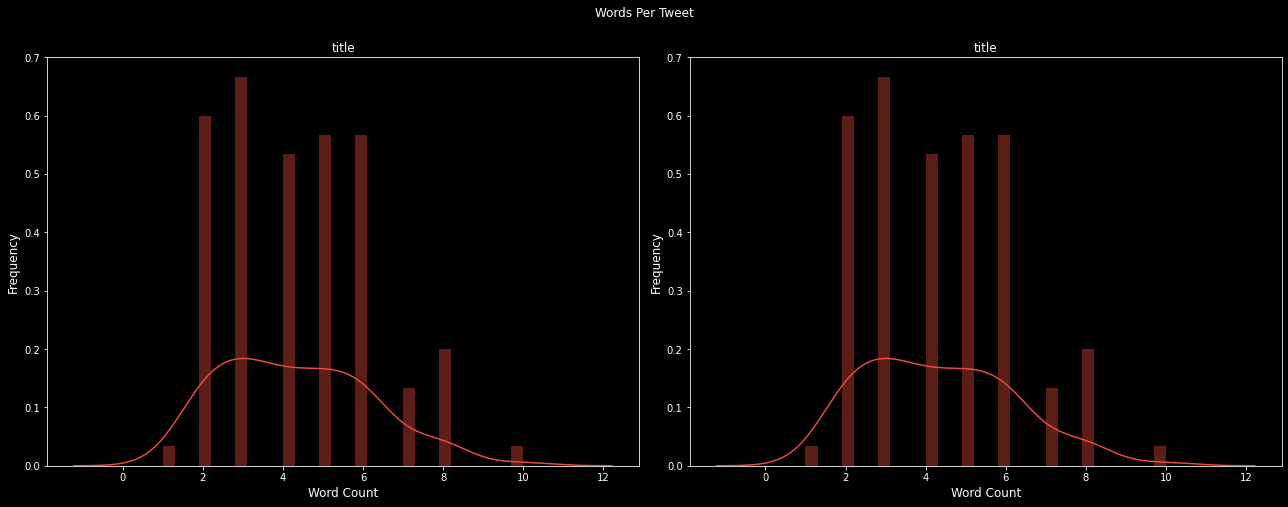

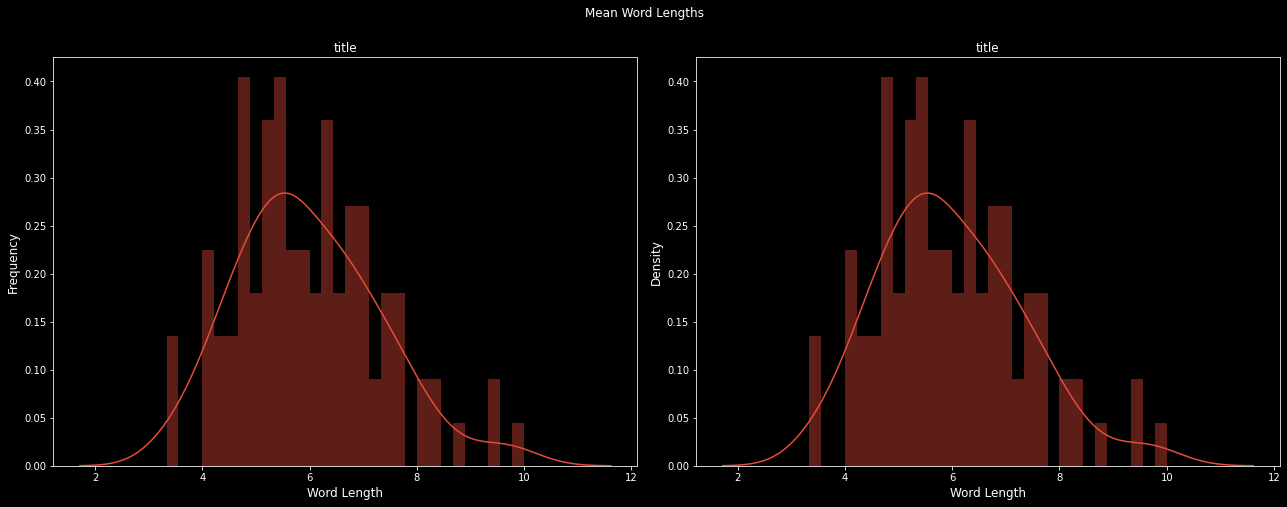

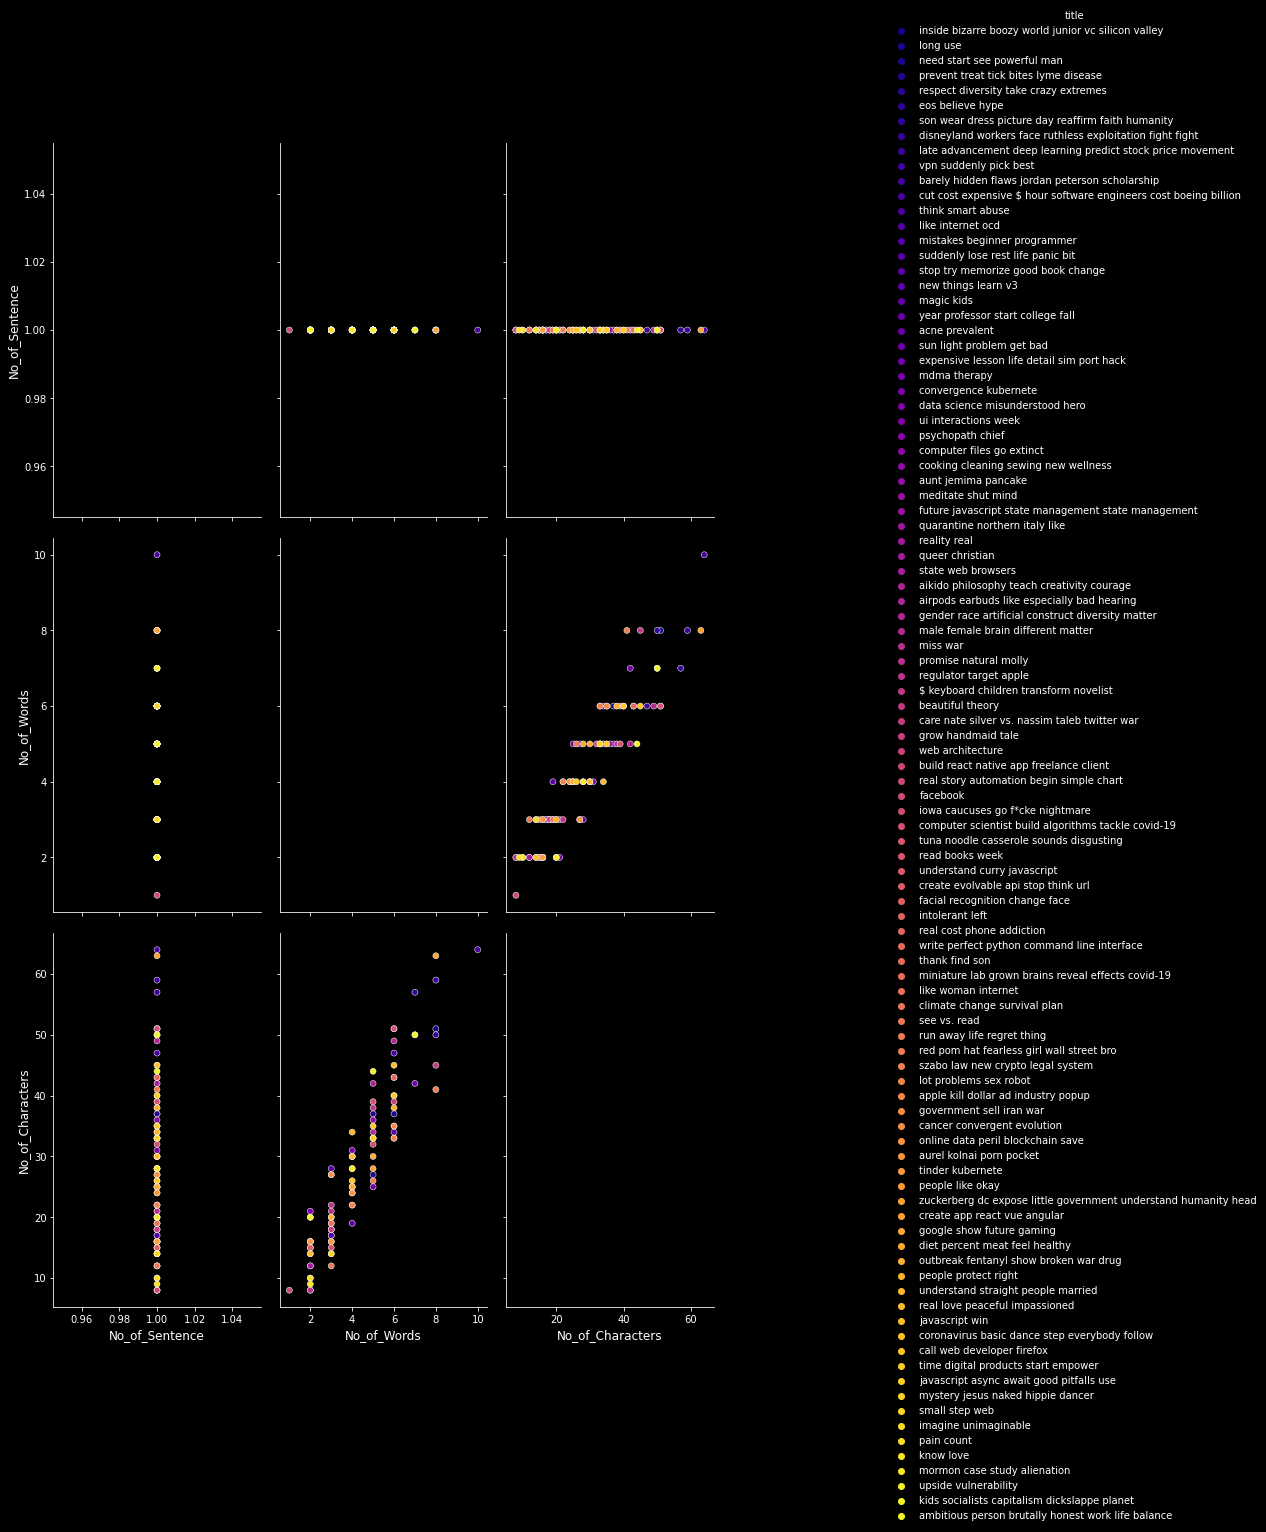

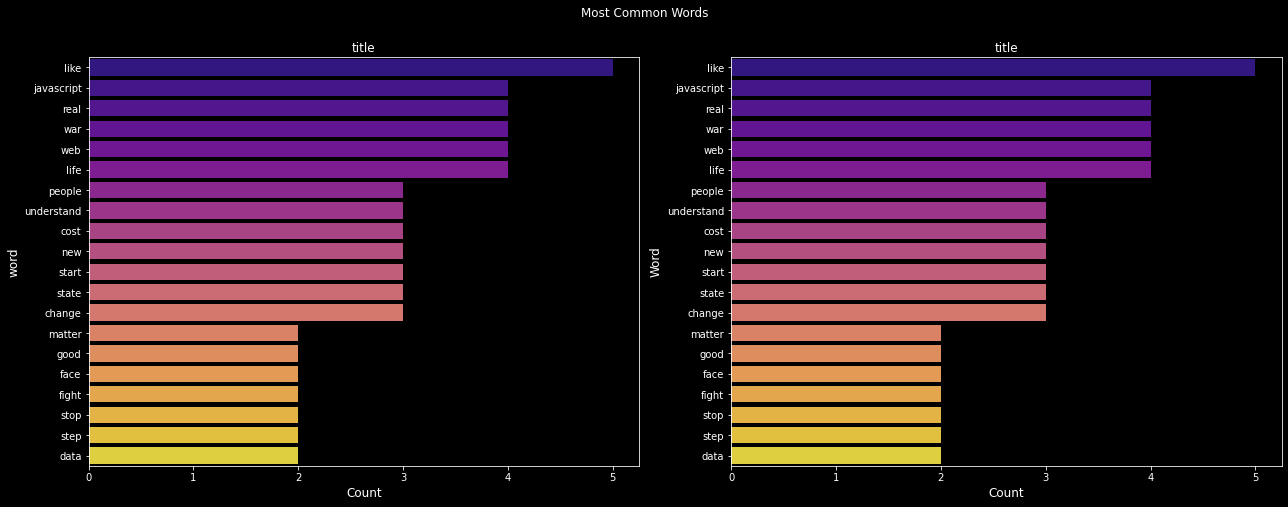

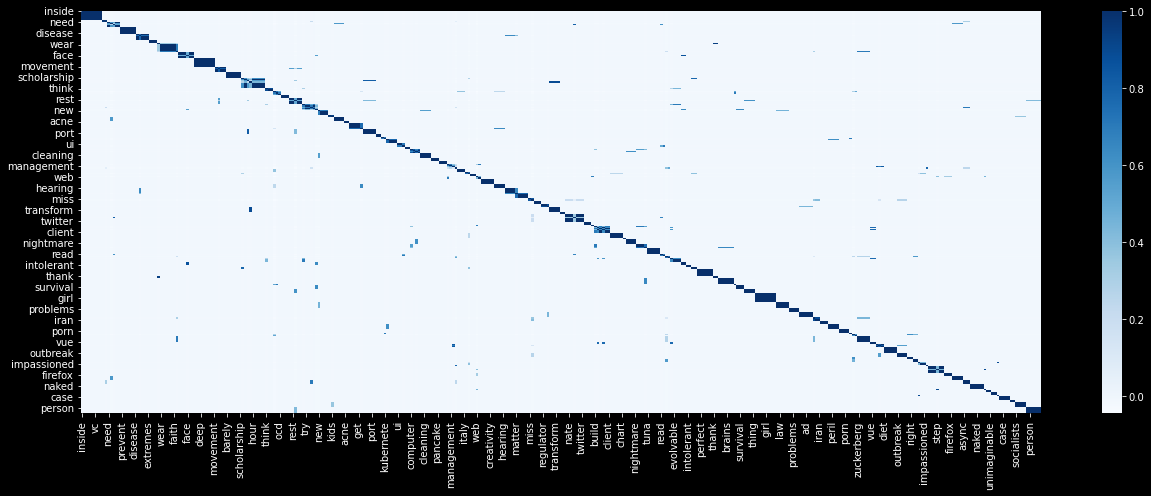

In [16]:
def word_cleanser(row):
    return re.sub(
        r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});|[@#]\w+|[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF\U00002702-\U000027B0\U000024C2-\U0001F251]+|https?://\S+|www\.\S+",
        "",
        row,
    )


def word_initializer(row):
    token = [
        token.lemma_.strip()
        for token in nlp(word_cleanser(row))
        if not token.is_punct
        and not token.is_stop
        and not token.like_email
        and not token.like_num
        and not token.like_url
    ]
    return " ".join(t.lower().strip() for t in token) if token else "."


def word_tokenizer(row):
    token = [
        token.lemma_.strip()
        for token in nlp(word_cleanser(row))
        if not token.is_punct
        and not token.is_stop
        and not token.like_email
        and not token.like_num
        and not token.like_url
    ]
    return token if token else ["."]


def word_vectorizer(X_series):
    if NLP:
        return np.concatenate(
            [
                arr
                for arr in X_series.apply(
                    lambda row: nlp(" ".join(word_tokenizer(row.lower()))).vector
                    if NLP
                    else word_tokenizer(row.lower().strip()),
                )
            ]
        ).reshape(-1, 300)
    else:
        return X_series.apply(
            lambda row: " ".join(word_tokenizer(row.lower().strip()))
        ).to_frame()


def tokenize_dataset(dataset):
    encoded = tokenizer(
        dataset,
        padding=True,
        truncation=True,
        return_tensors="np",
    )
    return encoded.data


def plot_target_pie():
    fig, axes = plt.subplots(ncols=2, nrows=1)
    sns.countplot(df_eda[y_label], ax=axes[0])
    axes[1].pie(
        df_eda[y_label].value_counts(),
        labels=["Not Disaster", "Disaster"],
        autopct="%1.2f%%",
        shadow=True,
        explode=(0.05, 0),
        startangle=60,
    )
    fig.suptitle("Distribution of the Tweets")
    plt.tight_layout()
    plt.show()


def plot_dist3(df_eda, feature, title):
    fig = plt.figure(constrained_layout=True)
    grid = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title("Histogram")
    sns.distplot(
        df_eda.loc[:, feature],
        hist=True,
        kde=True,
        ax=ax1,
        color="#e74c3c",
        bins=NUM_BINS,
    )
    ax1.set(ylabel="Frequency")

    ax2 = fig.add_subplot(grid[1, :2])
    ax2.set_title("Empirical CDF")
    sns.distplot(
        df_eda.loc[:, feature],
        ax=ax2,
        kde_kws={"cumulative": True},
        hist_kws={"cumulative": True},
        color="#e74c3c",
        bins=NUM_BINS,
    )
    ax2.set(ylabel="Cumulative Probability")

    ax3 = fig.add_subplot(grid[:, 2])
    ax3.set_title("Box Plot")
    sns.boxplot(x=feature, data=df_eda, orient="v", ax=ax3, color="#e74c3c")
    plt.suptitle(f"{title}")
    fig.tight_layout()


def plot_word_number_histogram(word_count_0, word_count_1):
    fig, axes = plt.subplots(1, 2)
    axes = axes.flatten()
    sns.distplot(word_count_0, ax=axes[0], color="#e74c3c", bins=NUM_BINS)
    sns.distplot(word_count_1, ax=axes[1], color="#e74c3c", bins=NUM_BINS)

    axes[0].set_xlabel("Word Count")
    axes[0].set_ylabel("Frequency")
    axes[0].set_title(f"{x_label}")
    axes[1].set_xlabel("Word Count")
    axes[1].set_ylabel("Frequency")
    axes[1].set_title(f"{x_label}")

    fig.suptitle("Words Per Tweet", va="baseline")
    fig.tight_layout()


def plot_word_len_histogram(x_label0, x_label1):
    fig, axes = plt.subplots(1, 2)
    axes = axes.flatten()
    sns.distplot(
        x_label0.str.split()
        .apply(lambda x: [len(i) for i in x])
        .map(lambda x: np.mean(x)),
        ax=axes[0],
        color="#e74c3c",
        bins=NUM_BINS,
    )
    sns.distplot(
        x_label1.str.split()
        .apply(lambda x: [len(i) for i in x])
        .map(lambda x: np.mean(x)),
        ax=axes[1],
        color="#e74c3c",
        bins=NUM_BINS,
    )

    axes[0].set_xlabel("Word Length")
    axes[0].set_ylabel("Frequency")
    axes[0].set_title(f"{x_label}")
    axes[1].set_xlabel("Word Length")
    axes[1].set_title(f"{x_label}")

    fig.suptitle("Mean Word Lengths", va="baseline")
    fig.tight_layout()
    plt.show()


def plot_top_words():
    fig, axes = plt.subplots(1, 2)
    axes = axes.flatten()
    if CLASSIFICATION:
        top_words0 = (
            pd.Series(
                [
                    word
                    for tweet_tokens in df_eda[df_eda[y_label] == 0]["Tokens"]
                    for word in tweet_tokens
                ]
            )
            .value_counts()
            .head(20)
        )
        top_words1 = (
            pd.Series(
                [
                    word
                    for tweet_tokens in df_eda[df_eda[y_label] == 1]["Tokens"]
                    for word in tweet_tokens
                ]
            )
            .value_counts()
            .head(20)
        )
    else:
        top_words0 = (
            pd.Series(
                [word for tweet_tokens in df_eda["Tokens"] for word in tweet_tokens]
            )
            .value_counts()
            .head(20)
        )
        top_words1 = (
            pd.Series(
                [word for tweet_tokens in df_eda["Tokens"] for word in tweet_tokens]
            )
            .value_counts()
            .head(20)
        )
    sns.barplot(x=top_words0.values, y=top_words0.index, palette="plasma", ax=axes[0])
    sns.barplot(x=top_words1.values, y=top_words1.index, palette="plasma", ax=axes[1])
    axes[0].set_xlabel("Count")
    axes[0].set_ylabel("word")
    axes[0].set_title(f"{x_label}")
    axes[1].set_xlabel("Count")
    axes[1].set_ylabel("Word")
    axes[1].set_title(f"{x_label}")

    fig.suptitle("Most Common Words", va="baseline")
    fig.tight_layout()
    plt.show()


def plot_pairplot():
    g = sns.pairplot(data=df_eda, hue=y_label, palette="plasma")
    g.fig.set_size_inches(18, 18)
    plt.show()


def grey_color_func(
    word, font_size, position, orientation, random_state=None, **kwargs
):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)


if len(col_cat_cv):
    import re
    import spacy

    nlp = spacy.load("en_core_web_lg", disable=["ner", "parser"])
    nlp.add_pipe("sentencizer")

    df_eda = df.sample(100, random_state=RANDOM_STATE)
    #     df_eda = df.copy()
    df_eda[x_label] = df_eda[x_label].apply(word_initializer)

    df_eda["No_of_Sentence"] = df_eda[x_label].apply(
        lambda text: len(list(nlp(text).sents))
    )
    df_eda["No_of_Words"] = df_eda[x_label].apply(lambda text: len(nlp(text)))
    df_eda["No_of_Characters"] = df_eda[x_label].apply(len)
    df_eda["Tokens"] = df_eda[x_label].apply(
        lambda x: [token.text.lower() for token in nlp(x)]
    )
    if CLASSIFICATION:
        plot_target_pie()
        plot_dist3(
            df_eda[df_eda[y_label] == 0],
            "No_of_Characters",
            'Characters Per "Non Disaster" Tweet',
        )
        plot_dist3(
            df_eda[df_eda[y_label] == 1],
            "No_of_Characters",
            'Characters Per "Disaster" Tweet',
        )
        plot_word_number_histogram(
            df_eda[df_eda[y_label] == 0]["No_of_Words"],
            df_eda[df_eda[y_label] == 1]["No_of_Words"],
        )
        plot_word_len_histogram(
            df_eda[df_eda[y_label] == 0][x_label], df_eda[df_eda[y_label] == 1][x_label]
        )
        plot_pairplot()
        plot_top_words()
        visualization_functions = [
            lambda: sns.scatterplot(
                x=df_eda["No_of_Words"],
                y=df_eda[x_label].apply(lambda text: len(text.split())),
                hue=df_eda[y_label],
                palette="plasma",
            ),
            lambda: sns.scatterplot(
                x=df_eda["No_of_Characters"],
                y=df_eda[x_label].apply(lambda text: len(text.split())),
                hue=df_eda[y_label],
                palette="plasma",
            ),
            lambda: sns.heatmap(
                df_eda.groupby(y_label).mean().corr(), annot=True, cmap="Blues"
            ),
            lambda: sns.heatmap(
                df_eda["Tokens"]
                .apply(lambda tokens: pd.Series(tokens).value_counts(normalize=True))
                .fillna(0)
                .corr(),
                cmap="Blues",
            ),
        ]

        for visualization_function in visualization_functions:
            visualization_function()
            plt.tight_layout()
            plt.show()
    else:
        plot_dist3(
            df_eda,
            "No_of_Characters",
            f"Characters Per '{x_label}'",
        )
        plot_word_number_histogram(
            df_eda["No_of_Words"],
            df_eda["No_of_Words"],
        )
        plot_word_len_histogram(df_eda[x_label], df_eda[x_label])
        plot_pairplot()
        plot_top_words()
        visualization_functions = [
            lambda: sns.heatmap(
                df_eda["Tokens"]
                .apply(lambda tokens: pd.Series(tokens).value_counts(normalize=True))
                .fillna(0)
                .corr(),
                cmap="Blues",
            ),
        ]

        for visualization_function in visualization_functions:
            visualization_function()
            plt.tight_layout()
            plt.show()

    nlp.remove_pipe("sentencizer")
    df_eda.drop(
        ["No_of_Characters", "No_of_Words", "No_of_Sentence", "Tokens"],
        axis=1,
        inplace=True,
    )


# Visualizing Wordcloud

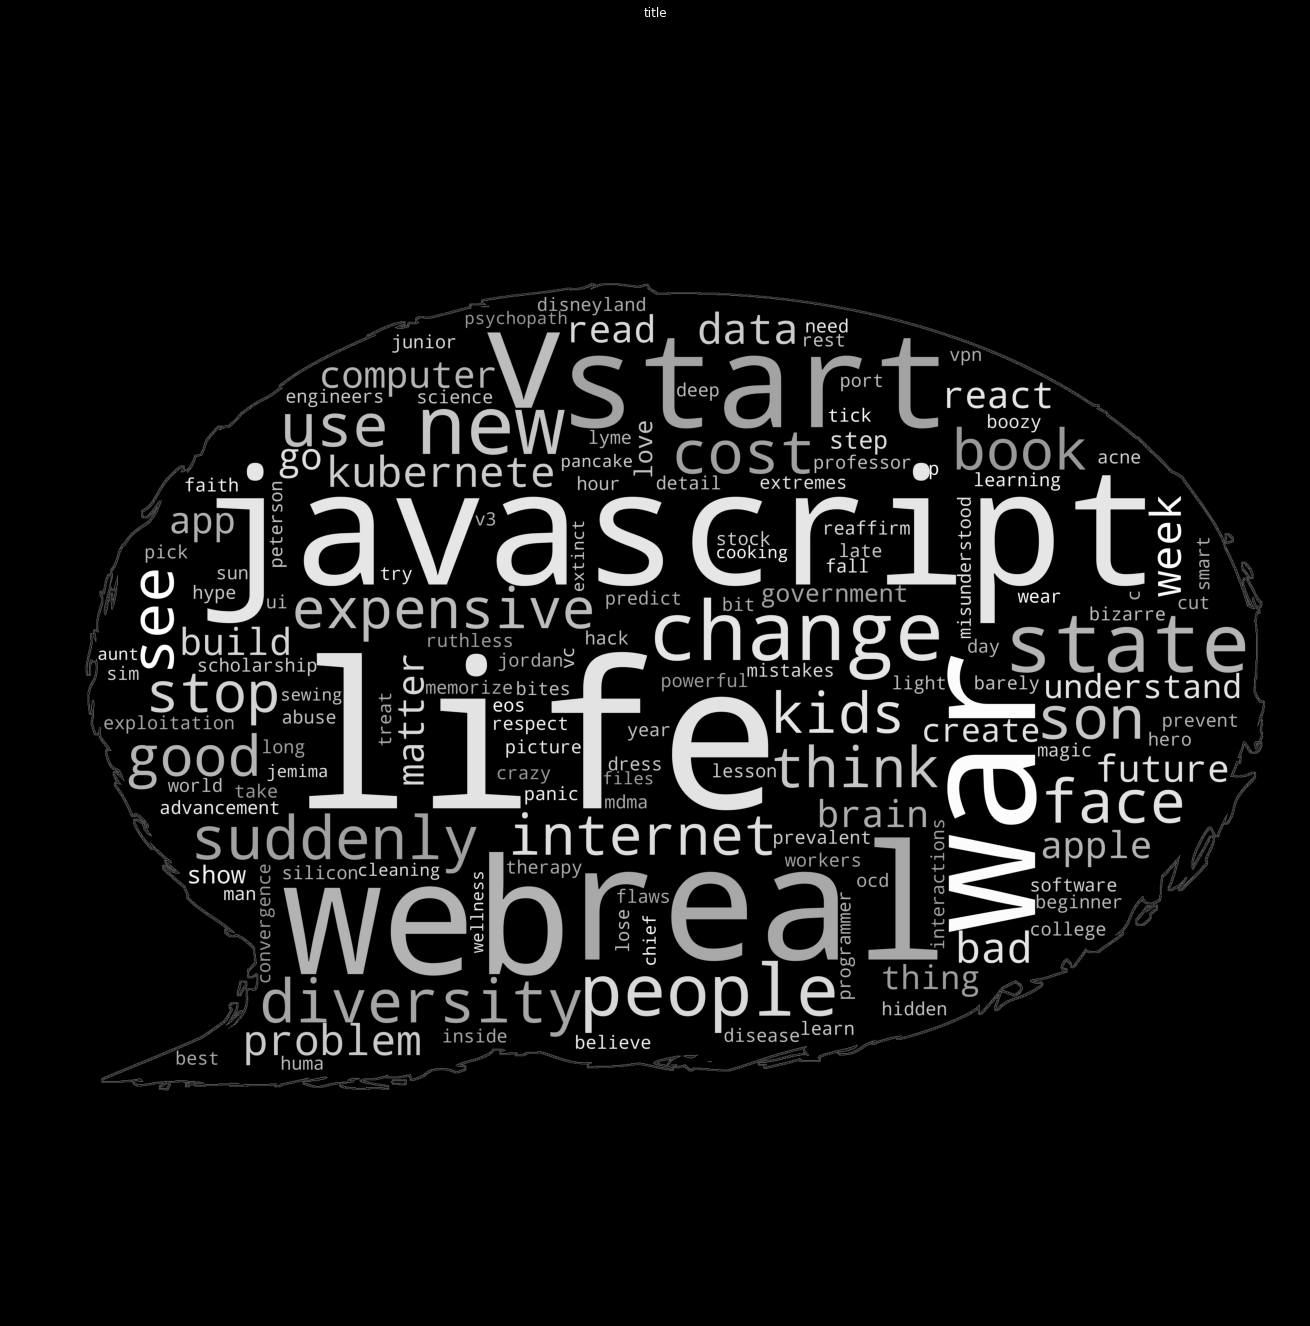

In [17]:
if len(col_cat_cv):
    from wordcloud import WordCloud

    mask = np.array(
        Image.open(
            BytesIO(
                requests.get(
                    "https://raw.githubusercontent.com/lyoh001/AzureML/main/mask.png"
                ).content
            )
        )
    )
    mask[mask.sum(axis=2) == 0] = 255

    for label in df_eda[y_label].unique() if CLASSIFICATION else [f"{x_label}"]:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 18))
        wordcloud = WordCloud(
            width=1200,
            height=800,
            max_words=150,
            background_color="black",
            scale=3,
            mask=mask,
            contour_width=0.1,
            contour_color="grey",
            collocations=False,
        ).generate(
            str(df_eda[df_eda[y_label] == label][next(iter(col_cat_cv))])
            if CLASSIFICATION
            else str(df_eda[next(iter(col_cat_cv))])
        )
        plt.imshow(
            wordcloud.recolor(color_func=grey_color_func, random_state=42),
            interpolation="bilinear",
        )
        ax.axis("off")
        plt.tight_layout(pad=0)
        ax.imshow(wordcloud)
        ax.set_title(y_index[label] if CLASSIFICATION else label)
        plt.show()


# Balancing the Sample Size

In [18]:
if DATA_BALANCE and CLASSIFICATION:
    df = df.sample(SAMPLE_SIZE, random_state=RANDOM_STATE)
    min_sample_size = df[y_label].value_counts().min()
    df = pd.concat(
        [
            df[df[y_label] == val].sample(min_sample_size)
            for val in df[y_label].unique()
        ],
        ignore_index=True,
    )
    print(df[y_label].value_counts())


# Feature Engineering and Data Pipeline (Impute, OHE, Scaling, Variance Threshold, PCA)

In [19]:
%%time
if CLASSIFICATION:
    X, y = df.drop(y_label, axis=1), df[y_label]
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        stratify=[None, y, y][CLASSIFICATION],
        random_state=RANDOM_STATE,
    )
    preprocessor_cat_ohe = make_pipeline(
        (SimpleImputer(strategy="constant", fill_value="missing")),
        (OneHotEncoder(handle_unknown="ignore", sparse=False)),
    )
    preprocessor_cat_cv = make_pipeline(
        [
            (FunctionTransformer(word_vectorizer)),
            (FunctionTransformer(word_vectorizer)),
            (TfidfVectorizer(tokenizer=word_tokenizer, ngram_range=[1, 1])),
            (CountVectorizer(tokenizer=word_tokenizer, ngram_range=[1, 1])),
        ][NLP]
    )
    preprocessor_num_disc = make_pipeline(
        (KNNImputer(n_neighbors=5)),
    )
    preprocessor_num_cont = make_pipeline(
        (KNNImputer(n_neighbors=5)),
    )
    preprocessor_col = make_column_transformer(
        (preprocessor_cat_oe, col_cat_oe),
        (preprocessor_cat_ohe, col_cat_ohe),
        (preprocessor_cat_cv, next(iter(col_cat_cv)) if len(col_cat_cv) else []),
        (preprocessor_num_disc, col_num_disc),
        (preprocessor_num_cont, col_num_cont),
        sparse_threshold=0
    )
    preprocessor = make_pipeline(
        (preprocessor_col),
        ([MinMaxScaler(), StandardScaler()][SCALER]),
        (VarianceThreshold(threshold=0)),
        (PCA())
    )
    X_train_processed, y_train_processed = preprocessor.fit_transform(X_train), y_train
    X_test_processed, y_test_processed = preprocessor.transform(X_test), y_test
    if CLASSIFICATION:
        class_weights = {i: w for i, w in enumerate(class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_train_processed), y=y_train_processed))}
        fig, ax = plt.subplots(nrows=1, ncols=3)
        sns.despine(left=True)
        sns.countplot(y, ax=ax[0]).set_xlabel("y")
        sns.countplot(y_train, ax=ax[1]).set_xlabel("y_train")
        sns.countplot(y_train_processed, ax=ax[2]).set_xlabel("y_train_processed")
        plt.show()
        print("-------------------------------------------------------")
        print(f"class_weights: {class_weights}")
        print("-------------------------------------------------------")
        print(f"y:\n{y.value_counts(normalize=True)}")
        print("-------------------------------------------------------")
        print(f"y_train:\n{y_train.value_counts(normalize=True)}")
        print("-------------------------------------------------------")
        print(f"y_train_processed:\n{y_train_processed.value_counts(normalize=True)}")
        print("-------------------------------------------------------")
        print(f"y_test:\n{y_test.value_counts(normalize=True)}")
        print("-------------------------------------------------------")
        print(f"y_test_processed:\n{y_test_processed.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"col_cat_oe ({len(col_cat_oe)}): {col_cat_oe}")
    print(f"col_cat_ohe ({len(col_cat_ohe)}): {col_cat_ohe}")
    print(f"col_num_disc ({len(col_num_disc)}): {col_num_disc}")
    print(f"col_num_cont ({len(col_num_cont)}): {col_num_cont}")
    print("-------------------------------------------------------")
    print(f"total cols for preprocessor: {len(col_cat_oe) + len(col_cat_ohe) + len(col_num_disc) + len(col_num_cont)}")
    print("-------------------------------------------------------")
    print(f"X: {X.shape}\tX_train: {X_train.shape}\tX_train_processed:{X_train_processed.shape}\tX_test: {X_test.shape}\t\tX_test_processed:{X_test_processed.shape}")
    print(f"y: {y.shape}\ty_train: {y_train.shape}\t\ty_train_processed:{y_train_processed.shape}\ty_test: {y_test.shape}\t\ty_test_processed:{y_test_processed.shape}")
    print("-------------------------------------------------------")
    if not NLP:
        tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)
        X_train_processed, X_test_processed = tokenize_dataset(X_train_processed.reshape(1, -1).tolist()[0]), tokenize_dataset(X_test_processed.reshape(1, -1).tolist()[0])

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10 µs


# Building, Hyper-param Tuning ML and ANN Models

In [20]:
if CLASSIFICATION:

    def tune_dl_model(hp):
        if NLP:
            model = keras.models.Sequential()
            model.add(
                keras.layers.Dense(
                    units=hp.Int("input_00_unit", min_value=32, max_value=512, step=32),
                    input_shape=X_train_processed.shape[1:],
                )
            )
            for i in range(hp.Int("num_layers", min_value=1, max_value=64)):
                model.add(
                    keras.layers.Dense(
                        units=hp.Int(
                            f"hidden_{i:02}_unit", min_value=32, max_value=512, step=32
                        ),
                        activation="relu",
                    )
                )
                model.add(
                    keras.layers.Dropout(
                        hp.Float("dropout", min_value=0, max_value=0.5, step=0.1)
                    )
                )
            model.add(
                keras.layers.Dense(
                    units=[1, 1, df[y_label].nunique()][CLASSIFICATION],
                    activation=["linear", "sigmoid", "softmax"][CLASSIFICATION],
                )
            )
        else:
            model = TFAutoModelForSequenceClassification.from_pretrained(
                PRETRAINED_MODEL, num_labels=2
            )

        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4, 1e-5])
            ),
            loss=[
                "mean_squared_error",
                "binary_crossentropy",
                "sparse_categorical_crossentropy",
            ][CLASSIFICATION]
            if NLP
            else keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=["mean_squared_error", "accuracy", "accuracy"][CLASSIFICATION],
        )
        return model

    def train_dl_model():
        tuner.search(
            X_train_processed,
            y_train_processed,
            batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
            callbacks=[early_stop],
            epochs=MAX_TRIALS,
            validation_split=0.2,
            verbose=1,
        )
        tuner.results_summary()

        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
        model = tuner.hypermodel.build(best_hps)
        history = model.fit(
            X_train_processed,
            y_train_processed,
            batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
            epochs=EPOCHS,
            validation_split=0.2,
            verbose=1,
            class_weight=class_weights if OVERSAMPLE else None,
        )
        val_per_epoch = history.history[
            ["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION]
        ]
        best_epoch = (
            val_per_epoch.index(
                [min(val_per_epoch), max(val_per_epoch), max(val_per_epoch)][
                    CLASSIFICATION
                ]
            )
            + 1
        )

        plt.subplot(1, 2, 1)
        sns.lineplot(
            data=history.history[
                ["mean_squared_error", "accuracy", "accuracy"][CLASSIFICATION]
            ],
            color="deeppink",
            linewidth=2.5,
        )
        sns.lineplot(
            data=history.history[
                ["val_mean_squared_error", "val_accuracy", "val_accuracy"][
                    CLASSIFICATION
                ]
            ],
            color="darkturquoise",
            linewidth=2.5,
        )
        plt.title("Model Accuracy")
        plt.ylabel("Accuracy")
        plt.xlabel("Epoch")
        plt.legend(["Training Accuracy", "Val Accuracy"], loc="lower right")
        plt.grid()

        plt.subplot(1, 2, 2)
        sns.lineplot(data=history.history["loss"], color="deeppink", linewidth=2.5)
        sns.lineplot(
            data=history.history["val_loss"], color="darkturquoise", linewidth=2.5
        )
        plt.title("Model Loss")
        plt.ylabel("Loss")
        plt.xlabel("Epoch")
        plt.legend(["Training Loss", "Val Loss"], loc="upper right")
        plt.grid()
        plt.show()

        print(f"Best epoch: {best_epoch}")

        return best_epoch, best_hps

    def build_dl_model(best_epoch, best_hps):
        model = tuner.hypermodel.build(best_hps)
        model.fit(
            X_train_processed,
            y_train_processed,
            batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
            epochs=best_epoch,
            validation_split=0.2,
            verbose=1,
            class_weight=class_weights if OVERSAMPLE else None,
        )
        print("-------------------------------------------------------")
        classification_report_test = classification_report(
            y_test_processed,
            np.argmax(model.predict(X_test_processed), axis=1)
            if CLASSIFICATION - 1
            else model.predict(X_test_processed).round()
            if NLP
            else tf.argmax(
                tf.nn.softmax(model.predict(X_test_processed).logits, axis=1), axis=1
            ).numpy(),
            output_dict=True,
        )
        print(
            f"accuracy: {classification_report_test['accuracy']:.3f} recall_macro: {classification_report_test['macro avg']['recall']:.3f} precision_macro: {classification_report_test['macro avg']['precision']:.3f} f1_macro: {classification_report_test['macro avg']['f1-score']:.3f} (Test)"
        )
        classification_report_train = classification_report(
            y_train_processed,
            np.argmax(model.predict(X_train_processed), axis=1)
            if CLASSIFICATION - 1
            else model.predict(X_train_processed).round()
            if NLP
            else tf.argmax(
                tf.nn.softmax(model.predict(X_train_processed).logits, axis=1), axis=1
            ).numpy(),
            output_dict=True,
        )
        print(
            f"accuracy: {classification_report_train['accuracy']:.3f} recall_macro: {classification_report_train['macro avg']['recall']:.3f} precision_macro: {classification_report_train['macro avg']['precision']:.3f} f1_macro: {classification_report_train['macro avg']['f1-score']:.3f} (Train)"
        )
        print("-------------------------------------------------------")
        print(
            classification_report(
                y_test_processed,
                np.argmax(model.predict(X_test_processed), axis=1)
                if CLASSIFICATION - 1
                else model.predict(X_test_processed).round()
                if NLP
                else tf.argmax(
                    tf.nn.softmax(model.predict(X_test_processed).logits, axis=1),
                    axis=1,
                ).numpy(),
            )
        )
        sns.heatmap(
            tf.math.confusion_matrix(
                y_test_processed,
                np.argmax(model.predict(X_test_processed), axis=1)
                if CLASSIFICATION - 1
                else model.predict(X_test_processed).round()
                if NLP
                else tf.argmax(
                    tf.nn.softmax(model.predict(X_test_processed).logits, axis=1),
                    axis=1,
                ).numpy(),
            ),
            cmap="Blues",
            fmt="d",
            annot=True,
            linewidths=1,
        )
        plt.xlabel("Predicted")
        plt.ylabel("Truth")

        return model

    if SEARCH == "hyperband":
        tuner = Hyperband(
            tune_dl_model,
            objective=["val_mean_squared_error", "val_accuracy", "val_accuracy"][
                CLASSIFICATION
            ],
            max_epochs=MAX_TRIALS,
            factor=3,
            directory=".",
            project_name="keras_tuner",
            overwrite=True,
        )
    elif SEARCH == "random":
        tuner = RandomSearch(
            tune_dl_model,
            objective=["val_mean_squared_error", "val_accuracy", "val_accuracy"][
                CLASSIFICATION
            ],
            max_trials=MAX_TRIALS,
            executions_per_trial=3,
            directory=".",
            project_name="keras_tuner",
            overwrite=True,
        )
    else:
        tuner = BayesianOptimization(
            tune_dl_model,
            objective=["val_mean_squared_error", "val_accuracy", "val_accuracy"][
                CLASSIFICATION
            ],
            max_trials=MAX_TRIALS,
            executions_per_trial=3,
            directory=".",
            project_name="keras_tuner",
            overwrite=True,
        )

    early_stop = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=int(MAX_TRIALS / 4)
    )
    tuner.search_space_summary()

else:

    class TextsDataset(Dataset):
        def __init__(self, txt_list, tokenizer, max_length):
            self.input_ids = []
            self.attn_masks = []
            self.labels = []
            for txt in txt_list:
                encodings_dict = tokenizer(
                    "<|startoftext|>" + txt + "<|endoftext|>",
                    truncation=True,
                    max_length=max_length,
                    padding="max_length",
                )
                self.input_ids.append(torch.tensor(encodings_dict["input_ids"]))
                self.attn_masks.append(torch.tensor(encodings_dict["attention_mask"]))

        def __len__(self):
            return len(self.input_ids)

        def __getitem__(self, idx):
            return self.input_ids[idx], self.attn_masks[idx]

    tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)
    model = AutoModelForCausalLM.from_pretrained(PRETRAINED_MODEL).to(
        torch.device(DEVICE)
    )
    print(
        f"The pre-trained model '{PRETRAINED_MODEL.upper()}' has been chosen and it will be trained on a {DEVICE.upper()}."
    )
    texts = pd.Series(df[x_label])
    max_length = min(max(len(tokenizer.encode(text)) for text in texts), 1024)

    tokenizer = AutoTokenizer.from_pretrained(
        PRETRAINED_MODEL,
        bos_token="<|startoftext|>",
        eos_token="<|endoftext|>",
        pad_token="<|pad|>",
    )
    model = AutoModelForCausalLM.from_pretrained(PRETRAINED_MODEL)
    model.resize_token_embeddings(len(tokenizer))

    dataset = TextsDataset(texts, tokenizer, max_length=max_length)
    train_size = int(0.9 * len(dataset))
    train_dataset, val_dataset = random_split(
        dataset, [train_size, len(dataset) - train_size]
    )
    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=3,
        logging_steps=100,
        save_steps=5000,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        warmup_steps=100,
        weight_decay=0.05,
        logging_dir="./logs",
        report_to="none",
        gradient_accumulation_steps=4,
        fp16=DEVICE == "cuda",
        learning_rate=5e-5,
    )


Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

The pre-trained model 'GPT2' has been chosen and it will be trained on a CUDA.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Building Neural Network Model

In [21]:
%%time
OVERSAMPLE = 0
if CLASSIFICATION:
    dl_model = build_dl_model(*train_dl_model())
else:
    Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=lambda data: {
            "input_ids": torch.stack([f[0] for f in data]),
            "attention_mask": torch.stack([f[1] for f in data]),
            "labels": torch.stack([f[0] for f in data]),
        },
    ).train()
    text = input("User Prompt:")
    input_ids = (
        tokenizer.encode("<|startoftext|> " + text, return_tensors="pt").cuda()
        if DEVICE == "cuda"
        else tokenizer.encode("<|startoftext|> " + text, return_tensors="pt")
    )
    output = model.generate(input_ids, max_length=max_length, do_sample=True)
    print(tokenizer.decode(output[0], skip_special_tokens=True))

Using cuda_amp half precision backend
***** Running training *****
  Num examples = 2430
  Num Epochs = 3
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 4
  Total optimization steps = 456


Step,Training Loss
100,11.237700
200,1.658700
300,1.509400
400,1.385500




Training completed. Do not forget to share your model on huggingface.co/models =)




User Prompt: Large Language Model has been trained.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Large Language Model has been trained. This one time, in a single, real experiment
CPU times: user 1min 31s, sys: 637 ms, total: 1min 31s
Wall time: 1min 46s


# Saving the LLM Model for Deployment

In [22]:
model.save_pretrained("llm_model")
tokenizer.save_pretrained("llm_model")
shutil.make_archive(f"llm_model", "zip", f"./llm_model")


Configuration saved in llm_model/config.json
Model weights saved in llm_model/pytorch_model.bin
tokenizer config file saved in llm_model/tokenizer_config.json
Special tokens file saved in llm_model/special_tokens_map.json


'/kaggle/working/llm_model.zip'